In [6]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
data = pd.read_csv("color_data.csv")
data.head()

,Day,r11,r12,r13,r21,r22,r23,r31,r32,r33,r41,r42,r43,r1_avg,r2_avg,r3_avg,r4_avg,r5_avg
0,4,255,216,3,102,239,228,176,226,79,79,55,174,158.00,189.67,160.33,102.67,150.89
1,5,255,53,53,140,106,189,39,125,239,122,174,138,120.33,145.00,134.33,144.67,141.33
2,6,3,104,255,131,70,238,31,57,104,144,127,157,120.67,146.33,64.00,142.67,117.67
3,7,180,104,180,248,78,53,83,240,81,138,69,229,154.67,126.33,134.67,145.33,135.44
4,8,53,154,53,239,181,170,204,99,27,117,216,192,86.67,196.67,110.00,175.00,160.56


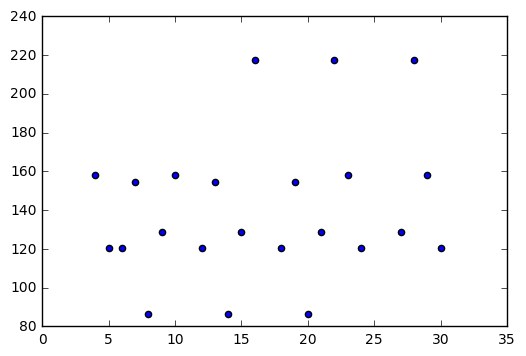

In [4]:
plt.scatter(data['Day'],data['r1_avg'])

# Training an RNN on the r1 colors
We attempt to train an RNN based the r1 color time-series with three features (RGB values). This procedure is modelled after this implementation of an RNN in keras: https://github.com/srikanthpagadala/neural-network-projects/tree/master/Time%20Series%20Prediction%20with%20LSTM%20Recurrent%20Neural%20Networks%20with%20Keras 

In [26]:
# For now, use all data for training

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :(len(dataset[0]))]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :len(dataset[0])])
    return np.array(dataX), np.array(dataY)

In [29]:
data_r1 = data[['r11','r12','r13']].values
X, Y = create_dataset(data_r1)
X


In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)